# Support Vector Machine

In [1]:
# WARNING: EXPENSIVE COMPUTING IF RUN_CALCULATION = True
# Calculation has already been done and saved in FILEPATH file and are reloaded from the file in this notebook
RUN_CALCULATION = False
LINEAR_SVM_GRID_FILEPATH     = 'saved_grid_search_results/svm_linear_grid.npy'
RBF_SVM_GRID_FILEPATH        = 'saved_grid_search_results/svm_rbf_grid.npy'
RBF_SVM_FOCUS_GRID_FILEPATH  = 'saved_grid_search_results/svm_rbf_grid_focus.npy'
LINEAR_SVM_MODEL_FILEPATH    = 'saved_best_models/svm_linear_model.npy'
RBF_SVM_MODEL_FILEPATH       = 'saved_best_models/svm_rbf_model.npy'

In [2]:
# Import functions used in the different notebooks of the course project
%run Tools.ipynb

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import datetime

## Load & Split Train/Test Sets

In [4]:
# Load the overfeat dataset
overfeat, _, labels, names = load_data()

# Check shapes
print('Overfeat shape:', overfeat.shape)
print('Labels shape:', labels.shape)

Overfeat shape: (5000, 4096)
Labels shape: (5000,)


In [5]:
# Split the train/test sets (4000/1000 stratified split)
X_train, X_test, y_train, y_test = split_data_stratified(overfeat, labels)
print('Train shape:', X_train.shape, y_train.shape)
print('Test shape:', X_test.shape, y_test.shape)

# Check the classes distribution in the test set
print('\nTest Classes Distribution:')
pd.value_counts(names[y_test])

Train shape: (4000, 4096) (4000,)
Test shape: (1000, 4096) (1000,)

Test Classes Distribution:


truck       250
ship        250
car         250
airplane    250
dtype: int64

## SVM with Linear Kernel

Linear support vector machine try to find an optimal hyperplane with margins to separate two classes, i.e, it is always a binary classifier. In our case, we have 4 classes, so the SVC algorithm builds behind the scene multiple binary classifiers depending the strategy used: 4 classifiers for One VS Others strategy or 6 for One VS One strategy and then aggregate the results obtained by each sub-classifier to attribute a class to a test data point. For One VS One strategy, the most voted class is attributed to the test data point. For One VS Others strategy, the attributed class is the one for which the test data point appears to be the farther from the hyperplane defined by the corresponding class sub-classifier. A point that lives in the good side from the hyperplane and far from it has a good chance to be from the class that the classifier try to predict. Note that only the `SVC` algorithm allows to use One VS One strategy.

In a nutshell, SVC try to find the best hyperplane that classify correctly the observations and in the same time try to maximize their distance (the margins) from this plane. In fact, very few data points will define these margins (called the support vectors) and the game become a trade-off between finding a solution that minimize the number of misclassifications but also a robust model that generalize well the data with an acceptable variance. Small margins allow to have models with low bias (few misclassifications) but because there are also few support vectors, with high variance. Reciproquely, bigger margins will allow more misclassifications (higher bias) but with margins defined by more support vectors, so less flexible, so a model with less variance. The C parameter in `LinearSVC` and `SVC` allows us to manage this bias/variance trade-off: small C value lead to bigger margins (high bias/low variance, potential underfitting), high C values lead to smaller margins (low bias/high variance, potential overfitting). 

For our model, we will use the `LinearSVC` algorithm that is computationally more efficient than its `SVC` with a linear kernel counterpart. Because by definition the SVC algorithm try to find an hyperplane in a N dimensional space to split two classes, we need probably to be less aggressive with our PCA pre-processing step and give it more degree of freedom to find it. So this time, we will keep 99% of the variance (1072 components). Note that we will also use the hinge loss function instead of the squared hinge loss function used by default by `LinearSVC` because it overfits the training data less quickly (in our case).

In [6]:
# Hyperparameters
svc__C = np.logspace(-6, 0, 40)

# Grid search calculation if not already computed previously or forced
if RUN_CALCULATION | (os.path.exists(LINEAR_SVM_GRID_FILEPATH) == False):
    
    # Pipeline estimator
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=1072, random_state=0)),  # 99% variance
        ('svc', LinearSVC(loss='hinge', multi_class='ovr', random_state=0))
    ])

    # Grid Search with Cross-Validation
    grid_cv = GridSearchCV(
        pipe,
        {
            'svc__C': svc__C
        },
        cv=5,  # 5 folds => 3200 train, 800 validation
        verbose=3
    )

    # Fit the model
    grid_cv.fit(X_train, y_train)
    
    # Save results in a numpy file
    np.save(LINEAR_SVM_GRID_FILEPATH, grid_cv)
else:
    # Load the grid search results from file
    grid_cv = np.load(LINEAR_SVM_GRID_FILEPATH, allow_pickle=True).item(0)

In [7]:
# Create a DataFrame to analyze the grid search results
df = pd.DataFrame.from_items([
    ('C', grid_cv.cv_results_['param_svc__C']),
    ('mean_training_accuracy', grid_cv.cv_results_['mean_train_score']),
    ('mean_validation_accuracy', grid_cv.cv_results_['mean_test_score']),
    ('training_standard_deviation', grid_cv.cv_results_['std_train_score']),
    ('validation_standard_deviation', grid_cv.cv_results_['std_test_score'])
])
df.sort_values(by=['mean_validation_accuracy', 'mean_training_accuracy'], ascending=False)
#df.sort_values(by=['C'], ascending=True)

,C,mean_training_accuracy,mean_validation_accuracy,training_standard_deviation,validation_standard_deviation
20,0.00119378,0.925563,0.83750,0.002266,0.014684
18,0.000587802,0.904500,0.83725,0.001320,0.017092
19,0.000837678,0.914500,0.83700,0.003021,0.016386
17,0.000412463,0.894313,0.83700,0.002141,0.016875
21,0.00170125,0.935375,0.83625,0.003121,0.015042
16,0.000289427,0.882437,0.83500,0.002846,0.015712
15,0.000203092,0.871125,0.83250,0.002079,0.012575
22,0.00242446,0.945250,0.82950,0.002720,0.013933
14,0.00014251,0.860500,0.82900,0.001922,0.010794
13,0.0001,0.852375,0.82400,0.003690,0.010350


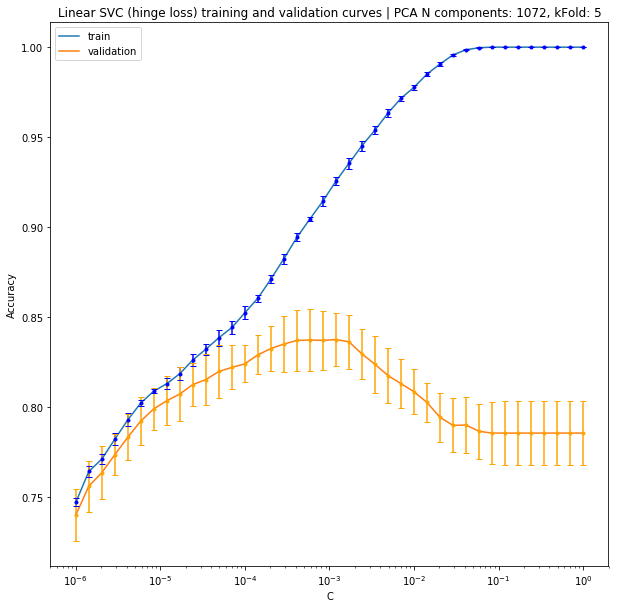

In [8]:
# Plot the training and validation curves
plt.figure(figsize=(10, 10))
plt.semilogx(df.C, df.mean_training_accuracy, label='train')
plt.semilogx(df.C, df.mean_validation_accuracy, label='validation')
plt.errorbar(df.C, df.mean_training_accuracy, df.training_standard_deviation, linestyle='None', marker='.', capsize=3, color='blue', label=None)
plt.errorbar(df.C, df.mean_validation_accuracy, df.validation_standard_deviation, linestyle='None', marker='.', capsize=3, color='orange', label=None)
plt.title('Linear SVC (hinge loss) training and validation curves | PCA N components: 1072, kFold: 5')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As expected, too high C values lead to overfitting and the accuracy validation curve follow the inverted U shape pattern. Note that the peak of the validation curve is somewhat flat with some oscillation. So, we will select the model that reach the first validation accuracy maximum (with the lower C).

In [9]:
def select_linear_svm_first_maximum_accuracy_model(grid):
    best_model = {}
    best_test_score = 0
    best_C = np.Inf
    results = grid.cv_results_
    mean_test_scores = results['mean_test_score']
    C = results['param_svc__C']
     
    # Find the C corresponding to the first validation accuracy maximum
    for i in range(len(mean_test_scores)):
        if mean_test_scores[i] > best_test_score:
            best_test_score = mean_test_scores[i]
            best_C = C[i]
        else:
            # we have already reached the first maximum, exit the loop
            
            # get the index corresponding to the best C model
            idx = np.where(results['param_svc__C'] == best_C)
            
            # return the model (each key)
            for key in results.keys():   
                if key == 'params':
                    continue
                best_model[key] = results[key][idx][0]
            return best_model

In [10]:
# Get the best model
best_model = select_linear_svm_first_maximum_accuracy_model(grid_cv)

# Print the hyperparameters of the best model
print('Linear SVM - top accuracy across folds: {:.3f} (std: {:.3f}) with C: {}'.format(
    best_model['mean_test_score'],
    best_model['std_test_score'],
    best_model['param_svc__C']
))

Linear SVM - top accuracy across folds: 0.837 (std: 0.017) with C: 0.0005878016072274912


### Linear SVC accuracy on the test set

In [11]:
if RUN_CALCULATION | (os.path.exists(LINEAR_SVM_MODEL_FILEPATH) == False):
    
    # Pipeline estimator
    svm_linear_model = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=1072, random_state=0)),  # 99% variance
        ('svc', LinearSVC(C=best_model['param_svc__C'], loss='hinge', multi_class='ovr', random_state=0))
    ])

    # Fit model on the full train set
    svm_linear_model.fit(X_train, y_train)

    # Save model in a numpy file
    np.save(LINEAR_SVM_MODEL_FILEPATH, svm_linear_model)
else:
    # Load the model from file
    svm_linear_model = np.load(LINEAR_SVM_MODEL_FILEPATH, allow_pickle=True).item(0)
    
# Evaluate accuracy on the test set
test_accuracy = svm_linear_model.score(X_test, y_test)
print('Linear SVC accuracy (test set): {:.3f}'.format(test_accuracy))

Linear SVC accuracy (test set): 0.830


By training the model with the selected hyperparameters on the full dataset, we obtain a test accuracy as predicted by the validation accuracy. Note that we obtain a better model than with kNN and decision tree/random forest. 

This time, the algorithm is less thight to the notion of data points proximity (kNN is based on neighbors and tree are based on pure regions). In the next section, we will try to build a SVM model with a RBF kernel. RBF kernel reintroduces again a notion of proximity with the euclidean distance between data points in its formulation. 

## SVM with RBF Kernel

The `SVC` classifier allows to use different kernels. RBK kernel add a new gamma hyperparameter to tune with grid search. The gamma parameter controls how much the points affect each other. Larger is the gamma value, closer the data points should be to produce significant kernel values.

In [12]:
# function to run RBF SVM grid search
def rbf_svm_grid_search(filename, C, gamma, n_components):
    
    # Grid search calculation if not already computed previously or forced
    if RUN_CALCULATION | (os.path.exists(filename) == False):
    
        # Pipeline estimator
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_components, random_state=0)),  # 99% variance
            ('svc', SVC(kernel='rbf', random_state=0))
        ])

        # Print start time
        print('Start time:', datetime.datetime.now().time())

        # Grid Search with Cross-Validation
        grid_cv = GridSearchCV(
            pipe,
            {
                'svc__C': C,
                'svc__gamma': gamma
            },
            cv=5,  # 5 folds => 3200 train, 800 validation
            verbose=3
        )

        # Fit the model
        grid_cv.fit(X_train, y_train)

        # Print end time
        print('End time:', datetime.datetime.now().time())
    
        # Save results in a numpy file
        np.save(filename, grid_cv)
    else:
        # Load the grid search results from file
        grid_cv = np.load(filename, allow_pickle=True).item(0)
        
    return grid_cv

In [13]:
# Hyperparameters
svc__C = np.logspace(-4, 5, 10)
svc__gamma = np.logspace(-7, 0, 8)

# RBF SVM Grid Search
grid_cv = rbf_svm_grid_search(RBF_SVM_GRID_FILEPATH, svc__C, svc__gamma, 1072)

In [14]:
# Create a DataFrame to analyze the grid search results
df = pd.DataFrame.from_items([
    ('C', grid_cv.cv_results_['param_svc__C']),
    ('Gamma', grid_cv.cv_results_['param_svc__gamma']),
    ('mean_accuracy_training', grid_cv.cv_results_['mean_train_score']),
    ('mean_accuracy_validation', grid_cv.cv_results_['mean_test_score']),
    ('standard_deviation_training', grid_cv.cv_results_['std_train_score']),
    ('standard_deviation_validation', grid_cv.cv_results_['std_test_score'])
])
df.sort_values(by='mean_accuracy_validation', ascending=False)

,C,Gamma,mean_accuracy_training,mean_accuracy_validation,standard_deviation_training,standard_deviation_validation
43,10,0.0001,0.994875,0.83950,0.000755,0.011635
57,1000,1e-06,0.958375,0.83475,0.001332,0.012104
64,10000,1e-07,0.957250,0.83475,0.001750,0.013634
75,100000,0.0001,1.000000,0.83350,0.000000,0.015236
35,1,0.0001,0.896563,0.83350,0.003446,0.010137
59,1000,0.0001,1.000000,0.83350,0.000000,0.015236
51,100,0.0001,1.000000,0.83350,0.000000,0.015236
67,10000,0.0001,1.000000,0.83350,0.000000,0.015236
50,100,1e-05,0.968813,0.83325,0.001403,0.011336
56,1000,1e-07,0.876812,0.83300,0.002756,0.010712


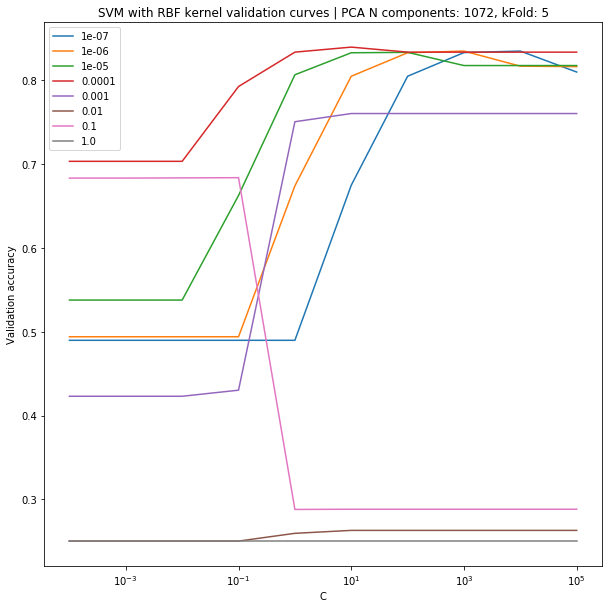

In [15]:
# Plot the training and validation curves
plt.figure(figsize=(10, 10))
for gamma in svc__gamma:
    filter = (df.Gamma == gamma)
    plt.semilogx(df.C[filter], df.mean_accuracy_validation[filter], label=gamma)

plt.title('SVM with RBF kernel validation curves | PCA N components: 1072, kFold: 5')
plt.xlabel('C')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

As expected, we see that most of the validation curves follow the inverted U shape pattern. Accuracy increases when C increases because the model become more flexible (lower bias/higher variance) and then decreases because the model overfits the training data too much.

It appears that gamma values greater than 1e-4 lead to bad results. It's interesting to note that the blue, orange and green curves look the same but translated to the right. When gamma is 10 times smaller, their maximum accuracy are reached for a C value 10 times greater. Instinctively, it would sound reasonable to keep the values of these two hyperparameters as close as possible.

Note that the blue and orange curves have an accuracy of 50% for low C values but green and red curves have better threshold. It let me think that gamma values under 1e-5 are not opiniated enough and doesn't bring power to the model. The red curve for gamma = 1e-4 is relatively flat and it could be a sign of overfitting.

Let's plots the training and validation curves for these 4 gamma values...

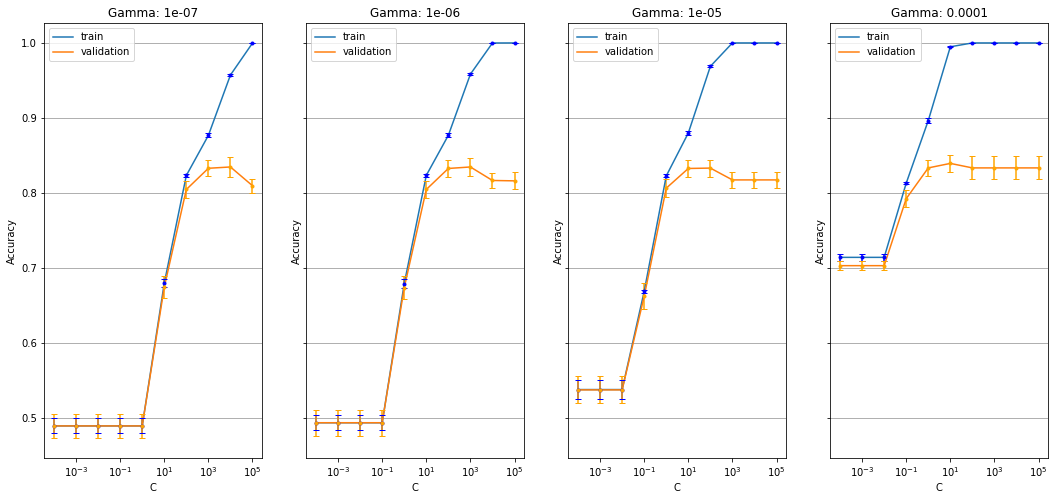

In [16]:
# Plot the training and validation curves for different gamma 
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(18, 8))
for i, ax in enumerate(axes.flatten()):
    filter = (df.Gamma == svc__gamma[i])
    ax.semilogx(df.C[filter], df.mean_accuracy_training[filter], label='train')
    ax.semilogx(df.C[filter], df.mean_accuracy_validation[filter], label='validation')
    ax.errorbar(df.C[filter], df.mean_accuracy_training[filter], df.standard_deviation_training[filter], linestyle='None', marker='.', capsize=3, color='blue', label=None)
    ax.errorbar(df.C[filter], df.mean_accuracy_validation[filter], df.standard_deviation_validation[filter], linestyle='None', marker='.', capsize=3, color='orange', label=None)
    ax.set(
        title='Gamma: {}'.format(svc__gamma[i]),
        xlabel='C',
        ylabel='Accuracy',
    )
    ax.grid(axis='y', linestyle='-', linewidth=1)
    ax.legend()
plt.show()

The right panel curves confirms that our model with a gamma value of 1e-4 overfits the training data. So it sounds a good idea to refine our tuning of C and gamma hyperparamters by restricting our grid search in the gamma range [1e-5, 1e-4]. Let's do that now... 

In [17]:
# Hyperparameters
svc__C = np.logspace(0, 3, 10)
svc__gamma = [1e-5, 3e-5, 5e-5, 7e-5, 1e-4]

# RBF SVM Grid Search
grid_cv = rbf_svm_grid_search(RBF_SVM_FOCUS_GRID_FILEPATH, svc__C, svc__gamma, 1072)

In [18]:
# Create a DataFrame to analyze the grid search results
df = pd.DataFrame.from_items([
    ('C', grid_cv.cv_results_['param_svc__C']),
    ('Gamma', grid_cv.cv_results_['param_svc__gamma']),
    ('mean_accuracy_training', grid_cv.cv_results_['mean_train_score']),
    ('mean_accuracy_validation', grid_cv.cv_results_['mean_test_score']),
    ('standard_deviation_training', grid_cv.cv_results_['std_train_score']),
    ('standard_deviation_validation', grid_cv.cv_results_['std_test_score']),
    ('mean_accuracy_difference', grid_cv.cv_results_['mean_train_score'] - grid_cv.cv_results_['mean_test_score'])
])
df.sort_values(by='mean_accuracy_validation', ascending=False)

,C,Gamma,mean_accuracy_training,mean_accuracy_validation,standard_deviation_training,standard_deviation_validation,mean_accuracy_difference
13,4.64159,7e-05,0.948438,0.84375,0.001843,0.013739,0.104688
18,10,7e-05,0.981937,0.84325,0.001879,0.012083,0.138687
17,10,5e-05,0.963125,0.84325,0.002006,0.012689,0.119875
14,4.64159,0.0001,0.972000,0.84225,0.001707,0.012283,0.129750
16,10,3e-05,0.932438,0.84075,0.002833,0.014155,0.091688
12,4.64159,5e-05,0.927500,0.84000,0.002554,0.012349,0.087500
19,10,0.0001,0.994875,0.83950,0.000755,0.011635,0.155375
9,2.15443,0.0001,0.934000,0.83950,0.003026,0.012614,0.094500
21,21.5443,3e-05,0.966250,0.83925,0.001665,0.015664,0.127000
25,46.4159,1e-05,0.939250,0.83800,0.003129,0.011446,0.101250


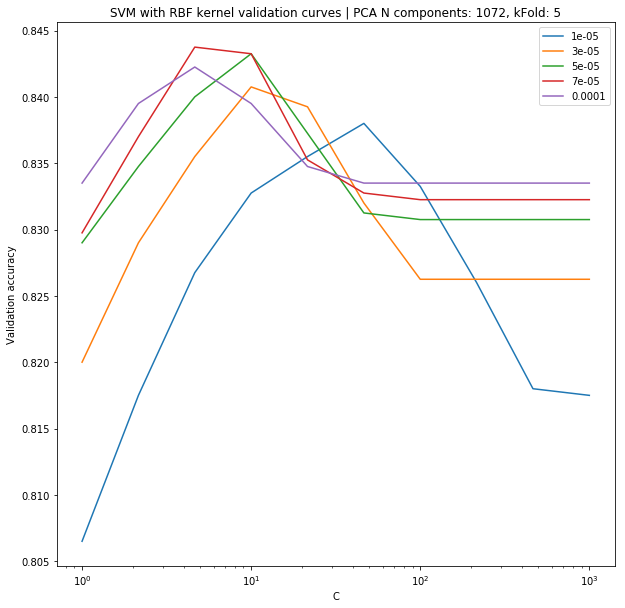

In [19]:
# Plot the training and validation curves
plt.figure(figsize=(10, 10))
for gamma in svc__gamma:
    filter = (df.Gamma == gamma)
    plt.semilogx(df.C[filter], df.mean_accuracy_validation[filter], label=gamma)

plt.title('SVM with RBF kernel validation curves | PCA N components: 1072, kFold: 5')
plt.xlabel('C')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

By looking these curves and the numbers behind the maximum of each of them, I would choose the gamma 3e-5 curve with its maximum value at C=10. It has sensibly the same accuracy but the smallest difference between the training and validation accuracy at its maximum. And we also know that gamma 1e-4 clearly overfit the data, so the 7e-5 and 5e-5 curves are probably again in the strong overfit side of the force...

So, we will create a function that return this model:  
* the model that has the lowest training/validation accuracy difference among the models with the highest accuracy obtained for each gamma

In [20]:
def select_rbf_svm_model(grid):
    best_models = []
    results = grid.cv_results_ 
    gammas  = grid_cv.param_grid['svc__gamma']
    Cs = grid_cv.param_grid['svc__C']
    
    # for each gamma curve, we want to find the best model 
    for g, gamma in enumerate(gammas):
        best_model = {}
        best_test_score = 0
        best_C = np.Inf
        
        filter = (results['param_svc__gamma'] == gamma)
        mean_test_scores = results['mean_test_score'][filter]
        
        # Find the C corresponding to the first validation accuracy maximum
        for i in range(len(Cs)):
            if mean_test_scores[i] > best_test_score:
                best_test_score = mean_test_scores[i]
                best_C = Cs[i]
            else:
                # we have already reached the first maximum, exit the loop
            
                # get the index corresponding to the best alpha model
                idx = np.where(results['param_svc__C'][filter] == best_C)
            
                # return the model (each key)
                for key in results.keys():   
                    if key == 'params':
                        continue
                    best_model[key] = results[key][filter][idx][0]
                
                # store the best model for this gamma value in the best models list
                best_models.append(best_model)
                break
    
    # return the model that has the lowest accuracy difference among the best model obtained for each gamma
    best_accuracy_diff = np.Inf
    best_model = {}
    for model in best_models:
        accuracy_diff = model['mean_train_score'] - model['mean_test_score']
        if accuracy_diff < best_accuracy_diff:
            best_accuracy_diff = accuracy_diff
            best_model = model
    
    return best_model           

In [21]:
# Get the best model
best_model = select_rbf_svm_model(grid_cv)

# Print the hyperparameters of the best model
print('RBF SVM - top accuracy across folds: {:.3f} (std: {:.3f}) with C: {} and gamma: {}'.format(
    best_model['mean_test_score'],
    best_model['std_test_score'],
    best_model['param_svc__C'],
    best_model['param_svc__gamma'],
))

RBF SVM - top accuracy across folds: 0.841 (std: 0.014) with C: 10.0 and gamma: 3e-05


### RBF SVM accuracy on the test set

In [22]:
if RUN_CALCULATION | (os.path.exists(RBF_SVM_MODEL_FILEPATH) == False):
    
    # Pipeline estimator
    svm_rbf_model = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=1072, random_state=0)),  # 99% variance
        ('svc', SVC(C=best_model['param_svc__C'], gamma=best_model['param_svc__gamma'], kernel='rbf', random_state=0))
    ])
    
    # Fit model on the full train set
    svm_rbf_model.fit(X_train, y_train)
    
    # Save model in a numpy file
    np.save(RBF_SVM_MODEL_FILEPATH, svm_rbf_model)
else:
    # Load the model from file
    svm_rbf_model = np.load(RBF_SVM_MODEL_FILEPATH, allow_pickle=True).item(0)
    
# Evaluate accuracy on the test set
test_accuracy = svm_rbf_model.score(X_test, y_test)
print('RBF SVM accuracy (test set): {:.3f}'.format(test_accuracy))

RBF SVM accuracy (test set): 0.842


We have improved again our model at the cost of a lot of computation time and also hard work to find the range of hyperparameters to tune with grid search. Overall, it is not a huge improvement from the linear SVM model that is more intuitive to understand. Once again, our cross-validation accuracy is a good prediction of the test accuracy.